In [1]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# Check GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA L40


In [3]:
# Load pre-trained CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = model.to(device)

In [4]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /home/jovyan/shared/clip_task


In [5]:
# Specify your directories
images_folder = "/home/jovyan/shared/dataset/data_seg/cityscapes/leftImg8bit/train"
captions_folder = "/home/jovyan/shared/dataset/data_seg/cityscapes/captions/train"

In [ ]:
# Helper function to recursively collect file paths
def collect_files(folder, extension):
    file_paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(extension):
                file_paths.append(os.path.join(root, file))
    return sorted(file_paths)

In [ ]:
# Collect image and caption files
image_files = collect_files(images_folder, '.png')[:1000]
caption_files = collect_files(captions_folder, '.txt')[:1000]

In [6]:
# Process and encode the first 10,000 images and captions
batch_size = 32  # Adjust based on your available memory
image_files = sorted([f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f)) and f.endswith('.png')])[:1000]
caption_files = sorted([f for f in os.listdir(captions_folder) if os.path.isfile(os.path.join(captions_folder, f)) and f.endswith('.txt')])[:1000]

if len(image_files) != len(caption_files):
    raise ValueError("The number of images and captions do not match.")

num_batches = len(image_files) // batch_size

In [7]:
# Initialize global lists for captions and image tensors
all_captions = []
all_image_tensors = []
all_image_files = []

image_features_list = []
text_features_list = []

for i in range(num_batches):
    batch_image_files = image_files[i * batch_size: (i + 1) * batch_size]
    batch_caption_files = caption_files[i * batch_size: (i + 1) * batch_size]

    # Debug: Print the current batch files
    print(f"Processing batch {i + 1}/{num_batches}")
    print(f"Batch image files: {batch_image_files}")
    print(f"Batch caption files: {batch_caption_files}")

    # Load and process images
    image_tensors = []
    for img_file in batch_image_files:
        try:
            image = Image.open(os.path.join(images_folder, img_file)).convert("RGB")
            image_tensors.append(image)
            all_image_files.append(img_file)  # Store the image file name

        except Exception as e:
            print(f"Error loading image {img_file}: {e}")

    # Load and process captions
    captions = []
    for cap_file in batch_caption_files:
        try:
            caption = open(os.path.join(captions_folder, cap_file)).read().strip()
            captions.append(caption)
        except Exception as e:
            print(f"Error loading caption {cap_file}: {e}")

    # Append to global lists
    all_captions.extend(captions)
    all_image_tensors.extend(image_tensors)
    
    # Print the features before encoding
    print(f"Before encoding - Batch {i + 1}:")
    print(f"Image tensors: {len(image_tensors)}, Captions: {len(captions)}")

    '''# Print the features before encoding
    if i == 0:  # Show features for the first batch only
        print(f"Before encoding - Batch {i + 1}:")
        print(f"Images (sample): {image_tensors[0].size}")
        print(f"Captions (sample): {captions[0]}")'''

    # Process batch if all files were loaded successfully
    if len(image_tensors) == len(batch_image_files) and len(captions) == len(batch_caption_files):
        inputs = processor(text=captions, images=image_tensors, return_tensors="pt", padding=True)
        
        # Move inputs to the device (GPU or CPU)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass through CLIP model
        with torch.no_grad():
            outputs = model(**inputs)

         # Print the features after encoding
        '''if i == 0:  # Show features for the first batch only
            print(f"After encoding - Batch {i + 1}:")
            print(f"Image embeddings shape (sample): {outputs.image_embeds[0].shape}")
            print(f"Text embeddings shape (sample): {outputs.text_embeds[0].shape}")'''

        # Print the features after encoding
        print(f"After encoding - Batch {i + 1}:")
        print(f"Image embeddings shape: {outputs.image_embeds.shape}")
        print(f"Text embeddings shape: {outputs.text_embeds.shape}")

        # Normalize the embeddings
        image_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)

        # Print the features after normalization
        print(f"After normalization - Batch {i + 1}:")
        print(f"Normalized image embeddings shape: {image_embeds.shape}")
        print(f"Normalized text embeddings shape: {text_embeds.shape}")

        # Move outputs to CPU and store them
        image_features_list.append(image_embeds.cpu())
        text_features_list.append(text_embeds.cpu())
    else:
        print("Skipping batch due to errors in loading files.")

Processing batch 1/31
Batch image files: ['00001.png', '00002.png', '00003.png', '00004.png', '00005.png', '00006.png', '00007.png', '00008.png', '00009.png', '00010.png', '00011.png', '00012.png', '00013.png', '00014.png', '00015.png', '00016.png', '00017.png', '00018.png', '00019.png', '00020.png', '00021.png', '00022.png', '00023.png', '00024.png', '00025.png', '00026.png', '00027.png', '00028.png', '00029.png', '00030.png', '00031.png', '00032.png']
Batch caption files: ['00001.txt', '00002.txt', '00003.txt', '00004.txt', '00005.txt', '00006.txt', '00007.txt', '00008.txt', '00009.txt', '00010.txt', '00011.txt', '00012.txt', '00013.txt', '00014.txt', '00015.txt', '00016.txt', '00017.txt', '00018.txt', '00019.txt', '00020.txt', '00021.txt', '00022.txt', '00023.txt', '00024.txt', '00025.txt', '00026.txt', '00027.txt', '00028.txt', '00029.txt', '00030.txt', '00031.txt', '00032.txt']
Before encoding - Batch 1:
Image tensors: 32, Captions: 32
After encoding - Batch 1:
Image embeddings sh

In [8]:
# Concatenate features from all batches
image_features = torch.cat(image_features_list, dim=0)
text_features = torch.cat(text_features_list, dim=0)

In [9]:
# Print the concatenated features' dimensions
print(f"Concatenated image features shape: {image_features.shape}")
print(f"Concatenated text features shape: {text_features.shape}")

Concatenated image features shape: torch.Size([992, 512])
Concatenated text features shape: torch.Size([992, 512])


In [10]:
# Compute cosine similarities between image features and caption features
cosine_similarities = F.cosine_similarity(
    image_features.unsqueeze(1),  # (num_images, 1, feature_dim)
    text_features.unsqueeze(0),  # (1, num_captions, feature_dim)
    dim=-1  # Compute similarity along the feature dimension
)

# Debug: Print shape of cosine_similarities
print(f"cosine_similarities shape: {cosine_similarities.shape}")
print(f"cosine_similarities: {cosine_similarities}")

cosine_similarities shape: torch.Size([992, 992])
cosine_similarities: tensor([[0.2593, 0.2287, 0.2398,  ..., 0.2586, 0.2273, 0.2519],
        [0.2397, 0.3112, 0.2382,  ..., 0.2782, 0.2676, 0.2521],
        [0.2188, 0.2031, 0.2615,  ..., 0.2700, 0.2508, 0.2610],
        ...,
        [0.2039, 0.2165, 0.2771,  ..., 0.2891, 0.2197, 0.2659],
        [0.1858, 0.2239, 0.2377,  ..., 0.2451, 0.2797, 0.2387],
        [0.1981, 0.2122, 0.2776,  ..., 0.2972, 0.2317, 0.2722]])


In [11]:
def show_image(image_path):
    image = Image.open(os.path.join(images_folder, image_path))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


Original image:


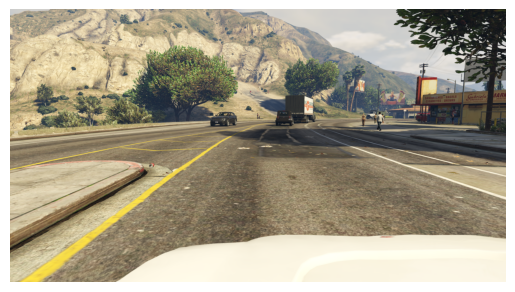

Original caption: there is a truck driving down the road in a game
len of all captions 992
Image index: 450, Most similar caption index: 808, Total captions: 992
Most similar caption: there is a truck driving down the road in a virtual world


In [12]:
# Function to find the most similar caption for a given image index
def find_most_similar_caption(image_idx):
    similarity_scores = cosine_similarities[image_idx]
    most_similar_caption_idx = torch.argmax(similarity_scores).item()
    print(f"Image index: {image_idx}, Most similar caption index: {most_similar_caption_idx}, Total captions: {len(all_captions)}")
    return all_captions[most_similar_caption_idx]

# Example usage
image_idx = 450  # Index of the image you want to query

# Show the original image
print("Original image:")
show_image(all_image_files[image_idx])

# Print the original caption and the most similar caption
print("Original caption:", all_captions[image_idx])
print("len of all captions", len(all_captions))
print("Most similar caption:", find_most_similar_caption(image_idx))

Original caption: there is a car driving down a street in a city
Caption index: 15, Most similar image index: 20, Total images: 992
Most similar image for the caption:


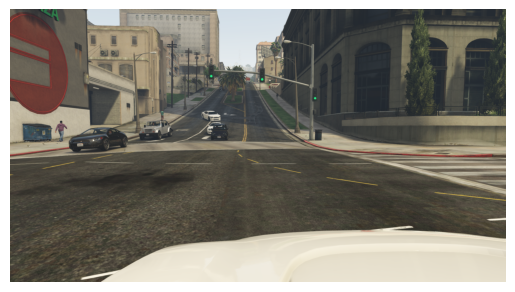

In [13]:
def find_most_similar_image(caption_idx):
    similarity_scores = cosine_similarities[:, caption_idx]
    most_similar_image_idx = torch.argmax(similarity_scores).item()
    print(f"Caption index: {caption_idx}, Most similar image index: {most_similar_image_idx}, Total images: {len(all_image_files)}")
    return all_image_files[most_similar_image_idx], most_similar_image_idx

caption_idx = 15  # Index of the caption you want to query

# Print the caption first
print(f"Original caption: {all_captions[caption_idx]}")

# Find and show the most similar image for the given caption
most_similar_image, most_similar_image_idx = find_most_similar_image(caption_idx)
print("Most similar image for the caption:")
show_image(most_similar_image)